<a href="https://colab.research.google.com/github/yvrjsharma/HugginFace_Gradio/blob/main/GradioApp_VisualGrounding_guided_Inpainting_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion along with Visual Grounding** 


## OFA

In [1]:
# clone OFA if there does not exist the repo
%cd /content
! git clone https://github.com/OFA-Sys/OFA.git

/content
Cloning into 'OFA'...
remote: Enumerating objects: 6187, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 6187 (delta 126), reused 149 (delta 76), pack-reused 5960
Receiving objects: 100% (6187/6187), 122.11 MiB | 24.29 MiB/s, done.
Resolving deltas: 100% (2415/2415), done.


In [2]:
%cd /content
! mkdir -p /content/OFA/checkpoints/
! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
! mv ofa_large_384.pt OFA/checkpoints/ofa_large.pt

/content
--2022-09-01 14:23:45--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6230622025 (5.8G) [application/octet-stream]
Saving to: ‘ofa_large_384.pt’

ofa_large_384.pt    100%[===================>]   5.80G  13.5MB/s    in 7m 28s  

2022-09-01 14:31:14 (13.3 MB/s) - ‘ofa_large_384.pt’ saved [6230622025/6230622025]



In [3]:
# clone Fairseq for installation
%cd /content
! git clone https://github.com/pytorch/fairseq.git
%cd /content/fairseq
! pip install --use-feature=in-tree-build ./

/content
Cloning into 'fairseq'...
remote: Enumerating objects: 32354, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 32354 (delta 48), reused 100 (delta 45), pack-reused 32243
Receiving objects: 100% (32354/32354), 22.49 MiB | 22.60 MiB/s, done.
Resolving deltas: 100% (23695/23695), done.
/content/fairseq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 123 kB 4.1 MB/s 
     |████████████████████████████████| 116 kB 31.3 MB/s 
     |████████████████████████████████| 235 kB 30.7 MB/s 
     |████████████████████████████████| 112 kB 71.7 MB/s 
  Created wheel for fairseq: filename=fairseq-0.12.2-cp37-cp37m-linux_x86_64.whl size=15415096 

In [4]:
%cd /content/OFA
! sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=e0d65974ce26a5a82e5a75aea320fb581f2f17ff37369c7bcd60a44bd2347ef9
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 124 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, 

In [5]:
import torch
import numpy as np
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from tasks.mm_tasks.refcoco import RefcocoTask

from models.ofa import OFAModel
from PIL import Image

tasks.register_task('refcoco', RefcocoTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
input_args = ["", "--task=refcoco", "--beam=10", "--path=checkpoints/ofa_large.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=384"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

In [6]:
# Load pretrained ckpt & config
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
task.cfg.patch_image_size

384

In [8]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)


def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int(round(coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)


def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip())) 
      if not word.startswith('<code_') and not word.startswith('<bin_') else word
      for word in text.strip().split()
    ]
    line = ' '.join(line)
    s = task.tgt_dict.encode_line(
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0)
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


## Visual Grounding Question

In [9]:
import cv2
import numpy
from google.colab.patches import cv2_imshow
import PIL

def get_ofa_visual_grounding(image, question):  #pil image as input
  # construct instruction
  w, h = image.size
  instruction = 'which region is the text " ' + question + ' " describe?' 

  # Construct input sample & preprocess for GPU if cuda available
  sample = construct_sample(image, instruction)
  sample = utils.move_to_cuda(sample) if use_cuda else sample
  sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

  # Generate result
  with torch.no_grad():
      hypos = task.inference_step(generator, models, sample)
      tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)

  # display result
  w_resize_ratio = task.cfg.patch_image_size / w
  h_resize_ratio = task.cfg.patch_image_size / h
  img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
  coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
  coords = [int(coord_list[0]), int(coord_list[1]), int(coord_list[2]), int(coord_list[3])]

  return coords, img #cv2_imshow(img)

## Image mask

In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def create_mask(coords, img):
  temp_mask_image = np.zeros(img.shape, dtype = "uint8")
  #plt.imshow(temp_mask_image, interpolation='nearest')
  #plt.show()
  mask_image = PIL.Image.fromarray(np.uint8(temp_mask_image)).convert("RGB") #.resize((512, 512))
  #coords = [int(coord_list[0]), int(coord_list[1]), int(coord_list[2]), int(coord_list[3])]
  mask_image.paste( (255,255,255), coords)       #[0,0,25,25])
  return mask_image


## Stable Diffusion - Setting up access to Huggingface Hub
You would have to sign into HuggingFace to access Stable Diffusion artifacts

In [11]:
!pip install -qq -U diffusers transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 112 kB 4.1 MB/s 
     |████████████████████████████████| 4.7 MB 19.3 MB/s 
     |████████████████████████████████| 53 kB 1.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.4 MB/s 
     |████████████████████████████████| 1.6 MB 4.1 MB/s 


In [15]:
from huggingface_hub import notebook_login

# Please enter your security token when prompted

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Stable Diffusion - Using Diffusers and InPainting 

In [16]:
#Code from Huggingface Diffusers Inpainting demo colab

import inspect
from typing import List, Optional, Union

import numpy as np
import torch 

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def preprocess_image(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

def preprocess_mask(mask):
    mask=mask.convert("L")
    w, h = mask.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    mask = mask.resize((w//8, h//8), resample=PIL.Image.NEAREST)
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = mask[None].transpose(0, 1, 2, 3)#what does this step do?
    mask = 1 - mask #repaint white, keep black
    mask = torch.from_numpy(mask)
    return mask


class StableDiffusionInpaintingPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        mask_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        #preprocess image
        init_image = preprocess_image(init_image).to(self.device)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)
        init_latents_orig = init_latents

        # preprocess mask
        mask = preprocess_mask(mask_image).to(self.device)
        mask = torch.cat([mask] * batch_size)

        #check sizes
        if not mask.shape == init_latents.shape:
            raise ValueError(f"The mask and init_image should be the same size!")


        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

            #masking
            init_latents_proper = self.scheduler.add_noise(init_latents_orig, noise, t)
            latents = ( init_latents_proper * mask ) + ( latents * (1-mask) )

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

In [17]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionInpaintingPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [18]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In [19]:
from torch import autocast
def inpaint(p, init_image, mask_image=None, strength=0.75, guidance_scale=7.5, generator=None, num_samples=1, n_iter=1):
    all_images = []
    for _ in range(n_iter):
        with autocast("cuda"):
            images = pipe(
                prompt=[p] * num_samples,
                init_image=init_image,
                mask_image=mask_image,
                strength=strength,
                guidance_scale=guidance_scale,
                generator=generator,
            )["sample"]
        all_images.extend(images)
    return all_images

In [20]:
#for seed
import random

def get_stable_diffusion_images(init_image, question, prompt):
  #prompt = "a cat sitting on bench"
  strength= .75
  guidance_scale=8.5
  num_samples = 4
  n_iter = 1

  #resize to 512
  init_image = init_image.resize((512, 512))
  #get mask
  coords, img = get_ofa_visual_grounding(init_image, question)  #pil image as input
  mask_image = create_mask(coords, img)
	
  generator = torch.Generator(device="cuda").manual_seed(random.randint(0,10000)) # change the seed to get different results
  print(f"generator is type:{type(generator)}, value:{generator}")
  all_images = inpaint(prompt, init_image, mask_image, strength=strength, guidance_scale=guidance_scale, generator=generator, num_samples=num_samples, n_iter=n_iter)

  return all_images

#some sample images
img_url1 = "https://drive.google.com/uc?export=download&id=1wCOSJDajr7As6mEvAH5Ze1W9qDQCABpd"
img_url2 = "https://drive.google.com/uc?export=download&id=1tFyeX0M7-yKpk_79bkNYSZd9KE0IJUUN"
img_url3 = "https://drive.google.com/uc?export=download&id=1cJl8PEOqKsYqAlDQovSjdlbbR_nClGTu"
img_url4 = "https://drive.google.com/uc?export=download&id=1OvMNZGQ2lOC-6XtvimS0iwbBihOkFx6T"

#for getting sample images
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

download_image(img_url1).resize((512, 512)).save('./dog.jpg')
download_image(img_url2).resize((512, 512)).save('./photobomb1.jpg')
download_image(img_url3).resize((512, 512)).save('./photobomb2.jpg')
download_image(img_url4).resize((512, 512)).save('./photobomb3.jpg')

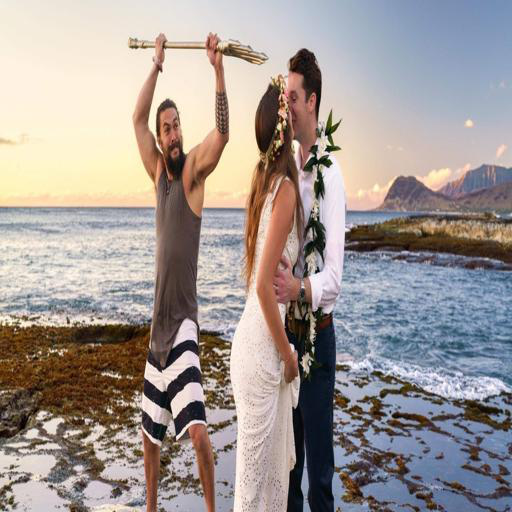

In [21]:
#sample
PIL.Image.open('./photobomb3.jpg')

## Building Gradio interface 

In [22]:
pip install -q gradio

     |████████████████████████████████| 6.1 MB 4.3 MB/s 
     |████████████████████████████████| 212 kB 79.9 MB/s 
     |████████████████████████████████| 112 kB 85.4 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 270 kB 96.2 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 2.3 MB 55.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 80 kB 10.1 MB/s 
     |████████████████████████████████| 68 kB 7.3 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 856 kB 61.5 MB/s 
     |████████████████████████████████| 4.1 MB 64.9 MB/s 
     |████████████████████████████████| 594 kB 71.6 MB/s 


In [23]:
import gradio as gr
import numpy as np
import os

In [27]:
demo = gr.Blocks()

examples = [['./dog.jpg', 'Dog', 'Cat sitting on bench'], 
            ['./photobomb2.jpg', 'bride', 'a giraffe'],
            ['./photobomb1.jpg', 'girl in blue dress', 'a man in blue shirt'],
            ['./photobomb3.jpg', 'man in shorts', 'a tree']]

    
with demo:
  gr.Markdown("<h1><center>Diffusing InPainting and Visual Grounding together</center></h1>")
  gr.Markdown(
        """<h3><center>Stable Diffusion - InPainting - OFA (ICML2022) Pipeline</center></h3>"""
        )
  with gr.Group():
    with gr.Box():
      with gr.Row().style(mobile_collapse=False, equal_height=True):
        with gr.Column(variant = 'panel'):
          in_image = gr.Image(type="pil") #(type='filepath') #(visible=False) type='numpy'
          in_txt_ofa_ques = gr.Textbox(label="Describe the region that you want to CHANGE in your picture? Take some help from the examples given.")
          in_txt_ofa_answr = gr.Textbox(label="Tell Stable Diffusion what you want instead - ")
          b1 = gr.Button("Diffuse some Magic!")

        with gr.Column(variant = 'panel'):  
          out_image = gr.Gallery(label='Diffused images').style(grid=[2,2], height="5", container=True)
          

      ex = gr.Examples(examples=examples, fn=get_stable_diffusion_images, inputs=[in_image, in_txt_ofa_ques, in_txt_ofa_answr], outputs=out_image, cache_examples=False)
      ex.dataset.headers = [""]    
        

      b1.click(get_stable_diffusion_images,inputs=[in_image, in_txt_ofa_ques, in_txt_ofa_answr], outputs=out_image)
  
demo.launch(show_error=True, debug=True, height=1000) #(enable_queue=True,  show_error=True , debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://35478.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


generator is type:<class 'torch._C.Generator'>, value:<torch._C.Generator object at 0x7f94f58482f0>


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


0it [00:00, ?it/s]

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f94f59bdc10>,
 'http://127.0.0.1:7860/',
 'https://35478.gradio.app')